In [8]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
sys.path.append('/home/manu/TFG_repo/scripts')  # make modules in scripts folder callable from notebooks

In [9]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from utide import solve
plt.style.use('/home/manu/TFG_repo/notebooks/notebook.mplstyle')

In [10]:
from analysis_functions import *

In [27]:
temp, pres, date, lat, lon = load_time_series('AGL_1_SB56.h5')

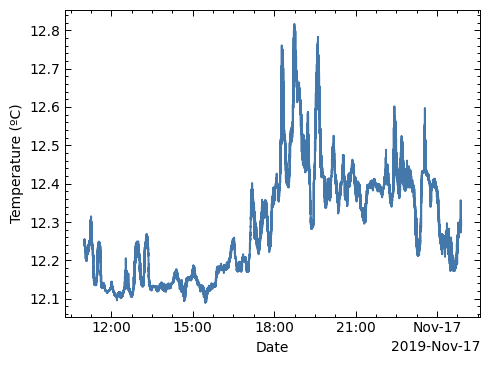

In [5]:
plot_single_thermistor(temp, pres, date, 8, lims=[0, 10000])

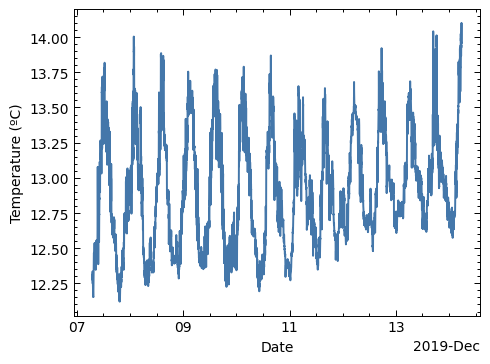

In [55]:
plot_single_thermistor(temp, pres, date, 9, lims=[30000, 40000])

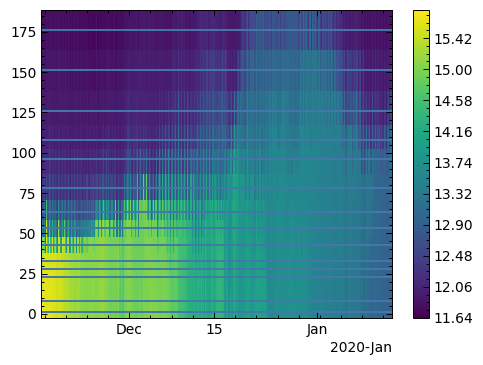

In [14]:
plot_column_temperature(temp, pres, date, lims=[0, 1000000], interval=1)

### U-Tide

In [11]:
# trim time series
dn = 12 # get datapoints every 60 seconds, not every 5
n_max = int(timedelta(days=30).total_seconds()/5)
date = date[:n_max:dn]
temp = temp[:, :n_max:dn]

NameError: name 'date' is not defined

In [29]:
coef = solve(date, temp[8], lat=lat)

solve: matrix prep ... solution ... done.


In [30]:
print(coef.keys())

dict_keys(['name', 'aux', 'nR', 'nNR', 'nI', 'weights', 'A', 'g', 'mean', 'slope', 'g_ci', 'A_ci', 'diagn', 'PE', 'SNR'])


In [47]:
help(solve)

Help on function solve in module utide._solve:

solve(t, u, v=None, lat=None, **opts)
    Calculate amplitude, phase, confidence intervals of tidal constituents.
    
    Parameters
    ----------
    t : array_like
        Time in days since `epoch`, or np.datetime64 array, or pandas datetime array.
    u : array_like
        Sea-surface height, velocity component, etc.
    v : {None, array_like}, optional
        If `u` is a velocity component, `v` is the orthogonal component.
    lat : float, required
        Latitude in degrees.
    epoch : {string, `datetime.date`, `datetime.datetime`}, if datenum is provided in t.
        Default `None` if `t` is `datetime`, `np.datetime64`, or `pd.datetime array.`
        Optional valid strings are
            - 'python' : if `t` is days since '0000-12-31'
            - 'matlab' : if `t` is days since '0000-00-00'
        Or, an arbitrary date in the form 'YYYY-MM-DD'.
    constit : {'auto', sequence}, optional
        List of strings with stand

### FFT

In [12]:
temp, pres, date, lat, lon = load_time_series('AGL_1_SB56.h5')

In [166]:
from scipy.fft import fft, fftfreq, ifft, rfft
from scipy.signal.windows import boxcar
from scipy.signal import welch

def detrend(x):
    n = len(x)
    t = np.arange(n)
    p = np.polyfit(t, x, 1)
    x_detrended = x - np.polyval(p, t)
    return x_detrended

def quadwindow(n):
    t = np.arange(n)
    win = 1- ((t - 0.5 * n) / (0.5 * n)) **2
    return win

def smooth(y, n):
    y_smoothed = np.convolve(y, boxcar(n), mode='valid')
    return y_smoothed

def spectrum(x, dt, n_smooth):
    '''Perform fft of series with spacing dt smoothin the 
    series with a quadratic window and block smoothing the 
    result with blocks of lenght n_smooth
    '''
    n = len(x)
    x = detrend(x)
    win_weights = quadwin(n)
    x *= win_weights
    
    pslice = slice(1, n//2)
    freqs = fftfreq(n, d=dt)[pslice]
    amplitude = rfft(x)[pslice]
    
    power = 2 * np.abs(amplitude)**2 / n**2
    psd = power * dt * n # power spectral density
    psd *= n / (win_weights**2).sum()
    power *= n**2 / win_weights.sum()**2
    
    freqs = smooth(freqs, n_smooth)
    psd = smooth(psd, n_smooth)
    power = smooth(power, n_smooth)
    
    return freqs, power, psd


def windowed_spectrum(x, dt, window_time, n_smooth, window='hann'):
    ''' Perform a windowed fourier transmor over time series x with
    spacing dt. Smooth out the results.
    '''
    N = len(x)
    window_n = window_time/dt
    freqs, psd = welch(x, fs=1/dt, nperseg=window_n, window=window, detrend='linear')
    freqs = smooth(freqs, n_smooth)
    psd = smooth(psd, n_smooth)
    
    return freqs, psd

def plot_spectrum(freqs, pxx, units, lims=None):
    period = 1/freqs
    fig, ax = plt.subplots()
    ax.loglog(period, psd)
    if lims != None:
        ax.set_xlim(*lims)
    ax.set_ylabel(r'Power spectral density (ºC$^2$/{})'.format(units))
    ax.set_xlabel(r'Period ({})'.format(units))
    plt.show()



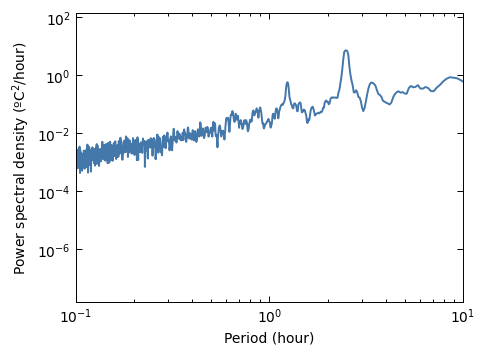

In [169]:
dt = 5/60/60
window_time = 1024
n_smooth = 5
units = 'hour'
freqs, psd = windowed_spectrum(temp[10], dt, window_time, n_smooth)
plot_spectrum(freqs, psd, 'hour', lims=(10**-1, 10))

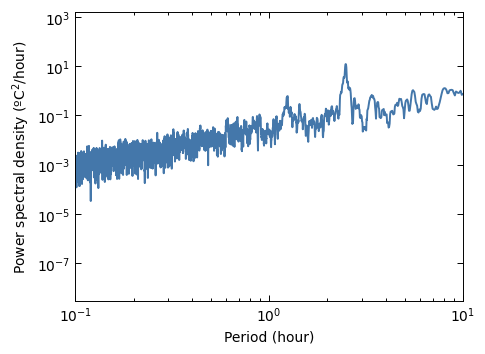

In [170]:
freqs, power, psd = spectrum(temp[10], dt, n_smooth)
plot_spectrum(freqs, psd, 'hour', lims=(10**-1, 10))